In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import defaultdict
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall
import seaborn as sns
from PIL import Image

2025-11-10 15:25:55.282089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762788355.731062      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762788355.863185      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
SEED=42
BATCH_SIZE=16

In [5]:
base_path='/kaggle/input/breakhis/BreaKHis_v1/'

In [6]:
folds = pd.read_csv('/kaggle/input/breakhis/Folds.csv')

In [7]:
benign_classes = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma']
malignant_classes = ['ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def get_labels(path):
    path_lower = path.lower()

    if 'benign' in path_lower:
        coarse_label = 'benign'
    else:
        coarse_label = 'malignant'

    fine_label = None
    for cls in benign_classes + malignant_classes:
        if cls in path_lower:
            fine_label = cls
            break

    return pd.Series([coarse_label, fine_label])

folds[['coarse_label', 'fine_label']] = folds['filename'].apply(get_labels)

In [8]:
folds['filename'] = folds['filename'].apply(lambda x: os.path.join(base_path, x))

In [9]:
folds.drop(columns=['fold','grp'], inplace=True)

In [10]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39545 entries, 0 to 39544
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mag           39545 non-null  int64 
 1   filename      39545 non-null  object
 2   coarse_label  39545 non-null  object
 3   fine_label    39545 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [11]:
folds.head(8)

,mag,filename,coarse_label,fine_label
0,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
1,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
2,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
3,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
4,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
5,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
6,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis
7,100,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...,benign,adenosis


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


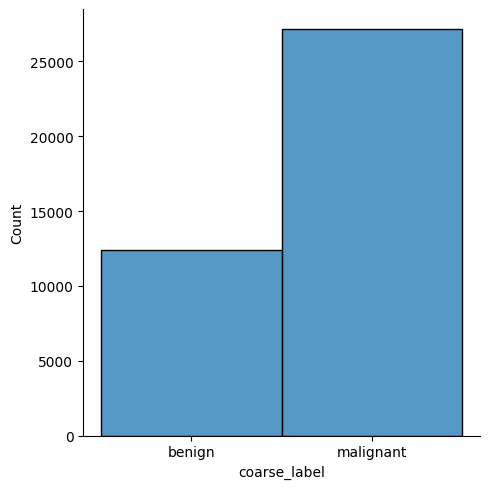

In [12]:
sns.displot(data=folds,x='coarse_label')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


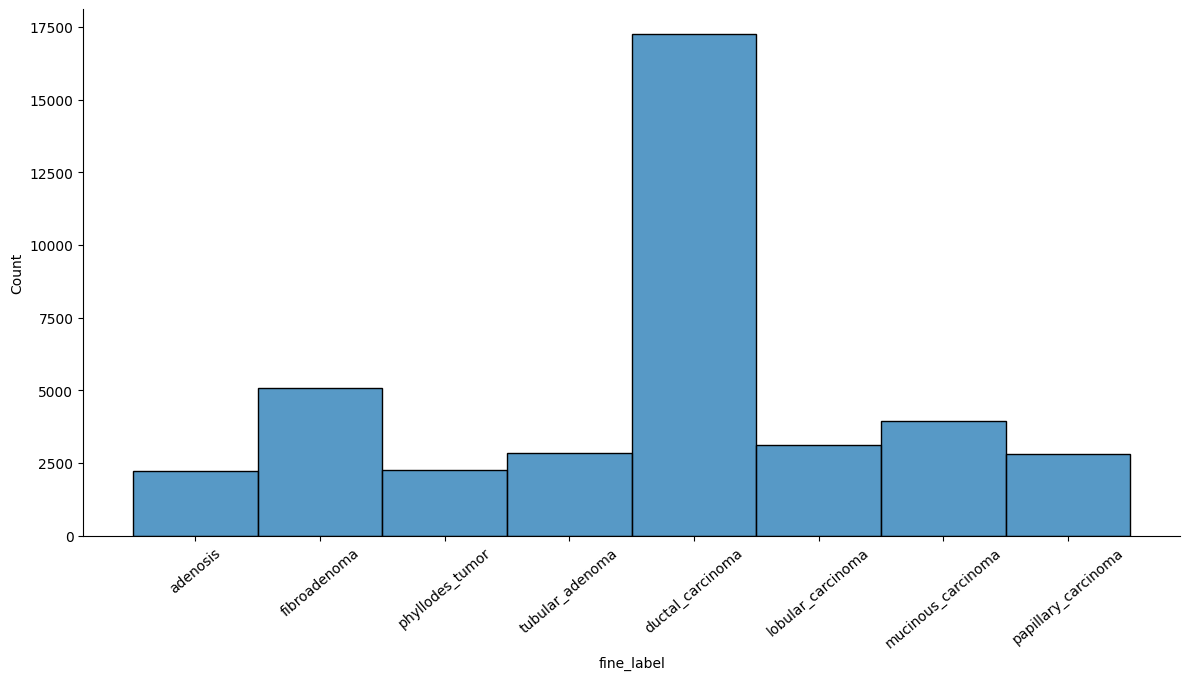

In [13]:
sns.displot(data=folds, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [14]:
test_df = folds.groupby('fine_label', group_keys=False).sample(n=850, random_state=SEED)
train_valid_df = folds.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

valid_df = train_valid_df.groupby('fine_label', group_keys=False).sample(frac=0.25, random_state=SEED)
train_df = train_valid_df.drop(valid_df.index).reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print('Training Set: ')
print(train_df['fine_label'].value_counts())
print('Total Count: ', train_df.shape[0])

print('Validation Set:')
print(valid_df['fine_label'].value_counts())
print('Total Count: ', valid_df.shape[0])

print('Test Set:')
print(test_df['fine_label'].value_counts())
print('Total Count: ', test_df.shape[0])

Training Set: 
fine_label
ductal_carcinoma       12304
fibroadenoma            3165
mucinous_carcinoma      2332
lobular_carcinoma       1710
tubular_adenoma         1496
papillary_carcinoma     1462
phyllodes_tumor         1061
adenosis                1028
Name: count, dtype: int64
Total Count:  24558
Validation Set:
fine_label
ductal_carcinoma       4101
fibroadenoma           1055
mucinous_carcinoma      778
lobular_carcinoma       570
tubular_adenoma         499
papillary_carcinoma     488
phyllodes_tumor         354
adenosis                342
Name: count, dtype: int64
Total Count:  8187
Test Set:
fine_label
adenosis               850
ductal_carcinoma       850
fibroadenoma           850
lobular_carcinoma      850
mucinous_carcinoma     850
papillary_carcinoma    850
phyllodes_tumor        850
tubular_adenoma        850
Name: count, dtype: int64
Total Count:  6800


     Train  Validation  Test
mag                         
40    6081        2091  1803
100   6510        2140  1755
200   6281        2087  1697
400   5686        1869  1545


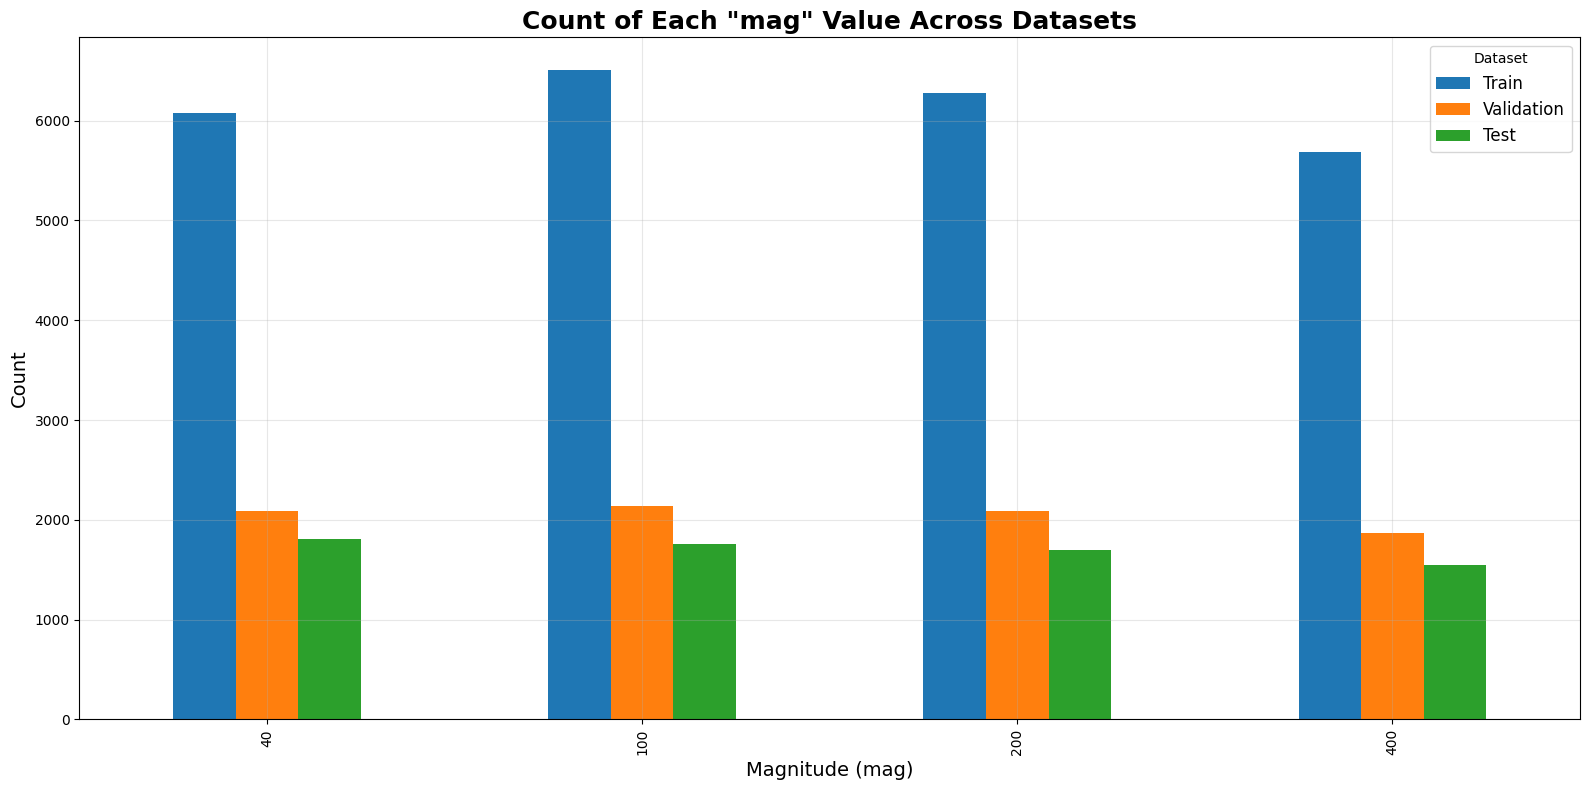

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Count occurrences of each mag per dataset
train_counts = train_df['mag'].value_counts().sort_index()
valid_counts = valid_df['mag'].value_counts().sort_index()
test_counts  = test_df['mag'].value_counts().sort_index()

# Combine into one DataFrame for comparison
mag_counts_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': valid_counts,
    'Test': test_counts
}).fillna(0).astype(int)

# Display table (optional)
print(mag_counts_df.head())

# Plot side-by-side bars
mag_counts_df.plot(kind='bar', figsize=(16, 8))
plt.title('Count of Each "mag" Value Across Datasets', fontsize=18, fontweight='bold')
plt.xlabel('Magnitude (mag)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Dataset', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


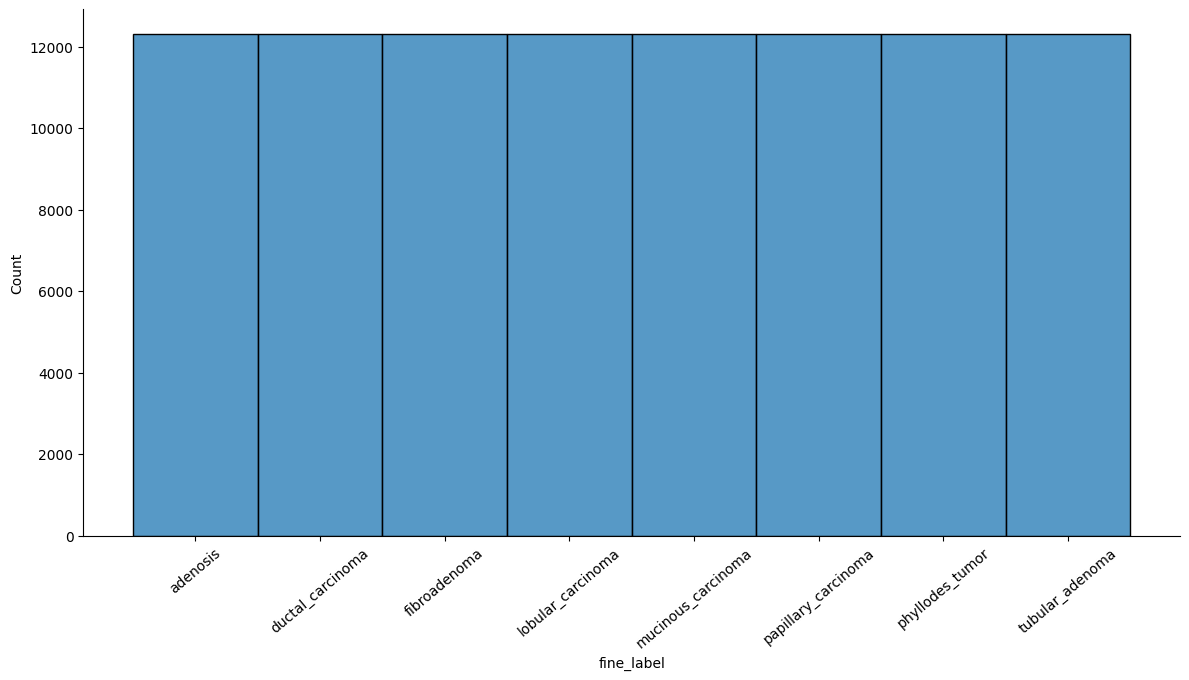

In [16]:
#upsampling
max_count = np.max(train_df.fine_label.value_counts())
min_count = np.min(train_df.fine_label.value_counts())
train_df = train_df.groupby('fine_label').sample(n=max_count, replace=True)
train_df = train_df.reset_index(drop=True)
train_df.fine_label.value_counts()

sns.displot(data=train_df, x='fine_label', height=6, aspect=2)
plt.xticks(rotation=40)
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='fine_label',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# train_subset = train_df.sample(frac=0.1, random_state=42)
# val_subset = valid_df.sample(frac=0.1, random_state=42)

# train_generator = train_datagen.flow_from_dataframe(
#     train_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

# val_generator = datagen.flow_from_dataframe(
#     val_subset,
#     x_col='filename',
#     y_col='fine_label',
#     target_size=(224, 224),
#     batch_size=16,
#     class_mode='categorical'
# )

Found 98432 validated image filenames belonging to 8 classes.
Found 8187 validated image filenames belonging to 8 classes.
Found 6800 validated image filenames belonging to 8 classes.


In [19]:
print(train_generator.image_shape)
print(val_generator.image_shape)
print(test_generator.image_shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


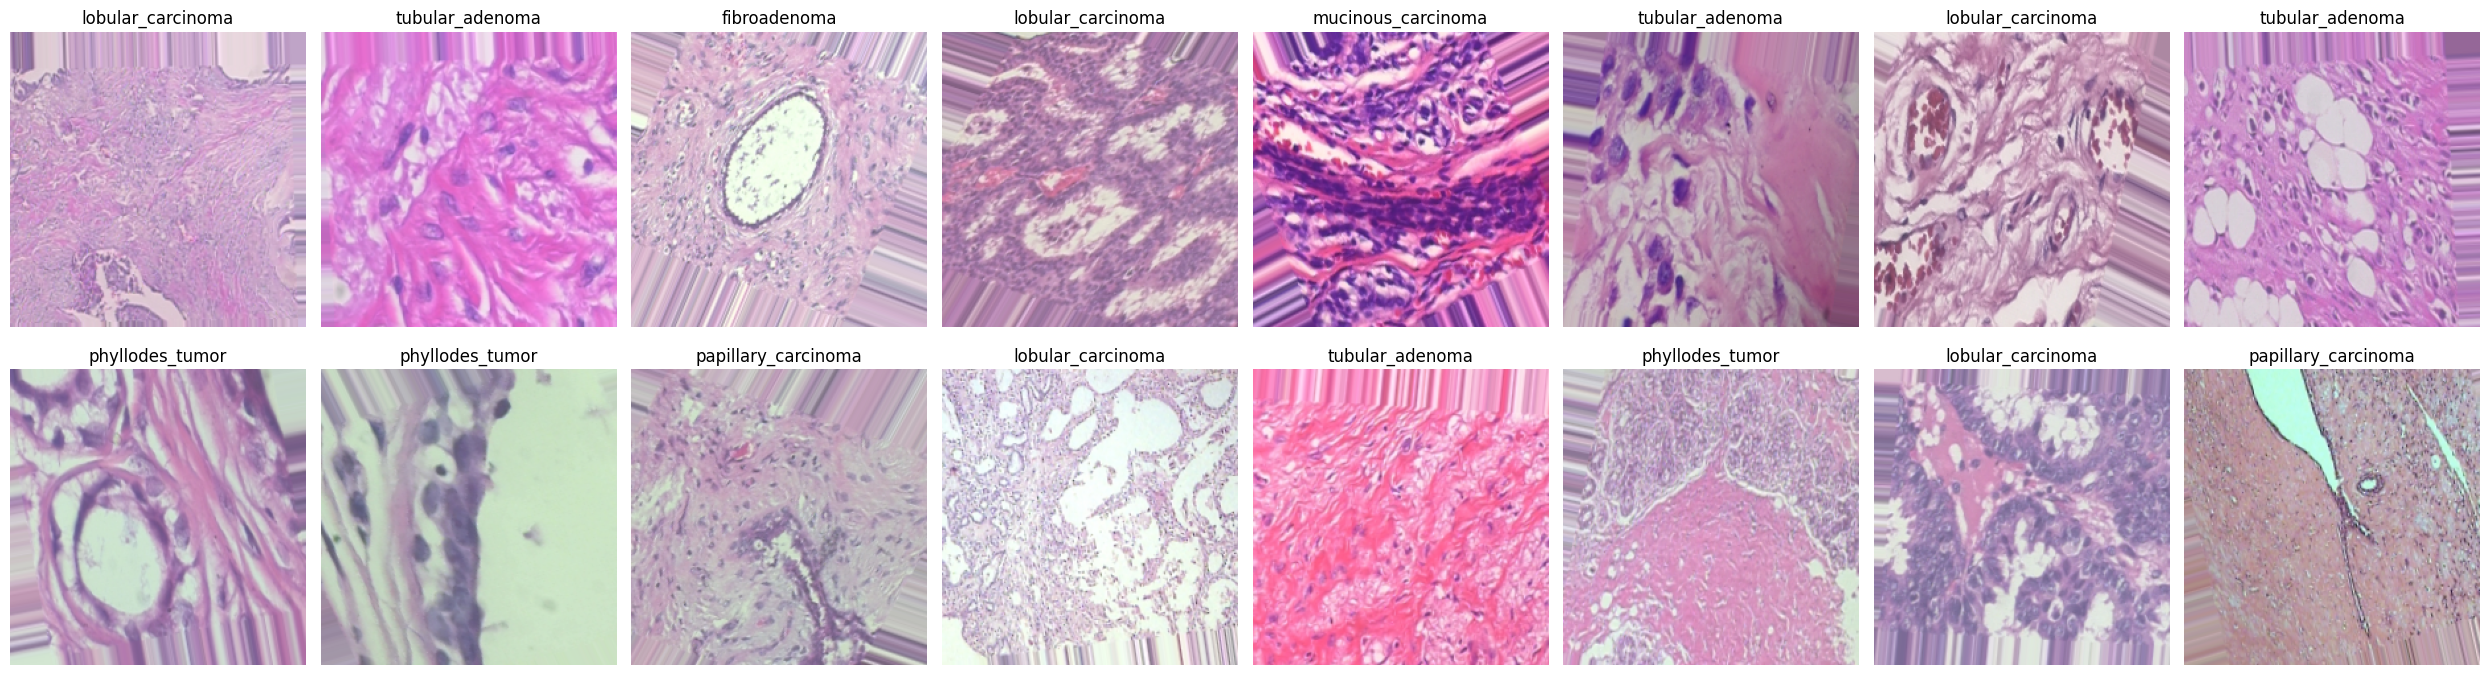

In [20]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['phyllodes_tumor', 'adenosis', 'fibroadenoma', 'tubular_adenoma','ductal_carcinoma', 'lobular_carcinoma', 'papillary_carcinoma', 'mucinous_carcinoma']

def view_image(generator, col=8, row=2, size=(25, 7)):
    images, labels = next(generator)
    total = len(images)
    plt.figure(figsize=size)
    plt.subplots_adjust(wspace=0.05, hspace=0.15)

    for i in range(total):
        ax = plt.subplot(row, col, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        plt.title(class_names[label_idx])
        plt.axis("off")

    plt.tight_layout()
    plt.show()


view_image(train_generator)

In [21]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import optimizers
from keras import Sequential, Model, backend as K
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

base_model = EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))

for layer in base_model.layers[:78]:
    layer.trainable = False
for layer in base_model.layers[78:]:
    layer.trainable = True

for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        continue

I0000 00:00:1762788427.849166      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762788427.849924      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(512,activation='gelu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256,activation='gelu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(8,activation='softmax'))

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,841,899 (18.47 MB)

 Trainable params: 4,725,922 (18.03 MB)

 Non-trainable params: 115,977 (453.04 KB)

In [24]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint = ModelCheckpoint(
    '/kaggle/working/efficientnet_78_freezed_on_breakhis_multiclass_model_epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

csv_logger = CSVLogger('training_log.csv', append=False)

In [25]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
      ]
)

In [26]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=17,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint,early_stop,csv_logger],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/17


I0000 00:00:1762788464.902189     117 service.cc:148] XLA service 0x7d9d50002fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762788464.903971     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762788464.903994     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762788469.677417     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762788478.004949     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762788478.144335     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762788478.468795     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

   1/6152 ━━━━━━━━━━━━━━━━━━━━ 112:35:10 66s/step - accuracy: 0.1250 - auc: 0.5142 - loss: 3.4791 - precision: 0.1250 - recall: 0.0625

I0000 00:00:1762788497.961581     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.6656 - auc: 0.9271 - loss: 0.9805 - precision: 0.7236 - recall: 0.6047
Epoch 1: val_accuracy improved from -inf to 0.78380, saving model to /kaggle/working/efficientnet_78_freezed_on_breakhis_multiclass_model_epoch_01_valacc_0.7838.weights.h5
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2477s 392ms/step - accuracy: 0.6656 - auc: 0.9271 - loss: 0.9804 - precision: 0.7237 - recall: 0.6047 - val_accuracy: 0.7838 - val_auc: 0.9735 - val_loss: 0.6070 - val_precision: 0.8048 - val_recall: 0.7644
Epoch 2/17
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8896 - auc: 0.9906 - loss: 0.3222 - precision: 0.9036 - recall: 0.8764
Epoch 2: val_accuracy improved from 0.78380 to 0.87786, saving model to /kaggle/working/efficientnet_78_freezed_on_breakhis_multiclass_model_epoch_02_valacc_0.8779.weights.h5
6152/6152 ━━━━━━━━━━━━━━━━━━━━ 2252s 366ms/step - accuracy: 0.8896 - auc: 0.9906 - loss: 0.3222 - precision: 0.9036 - recall: 0.8764 - val_accur

In [27]:
loss, accuracy,auc,precision,recall = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Recall: {recall*100:.2f}%")

425/425 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 0.9804 - auc: 0.9994 - loss: 0.0540 - precision: 0.9810 - recall: 0.9798
Test Loss: 0.0583
Test Accuracy: 98.26%
Test Precision: 98.19%
Test Recall: 99.90%


In [28]:
def plot_history(history):
    val_loss = history.history['val_loss' ]
    loss =     history.history['loss' ]
    acc =      history.history['accuracy' ]
    val_acc =  history.history['val_accuracy' ]

    epochs    = range(1,len(acc)+1,1)

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot  ( epochs,     loss, 'r--', label='Training loss' )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

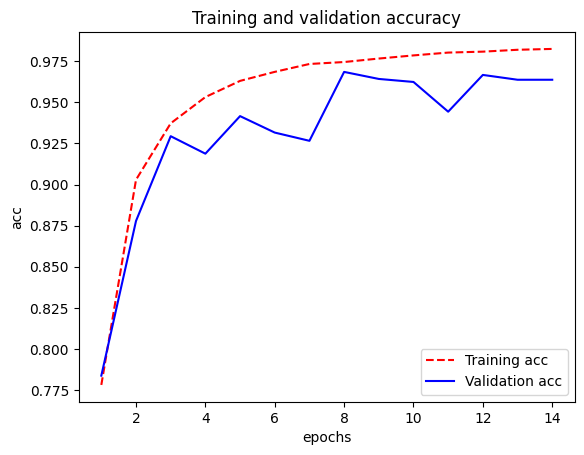

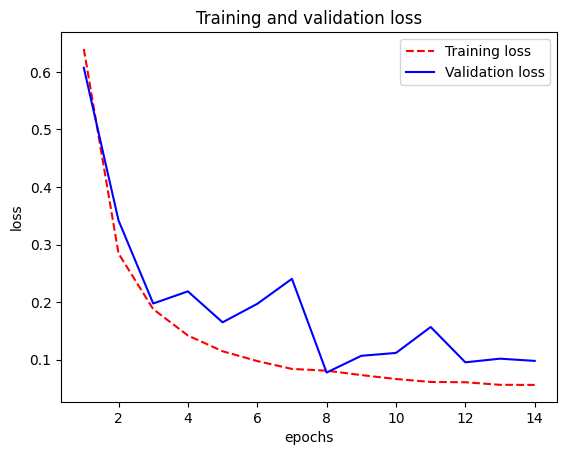

<Figure size 640x480 with 0 Axes>

In [29]:
plot_history(history)

425/425 ━━━━━━━━━━━━━━━━━━━━ 89s 198ms/step


<Figure size 800x800 with 0 Axes>

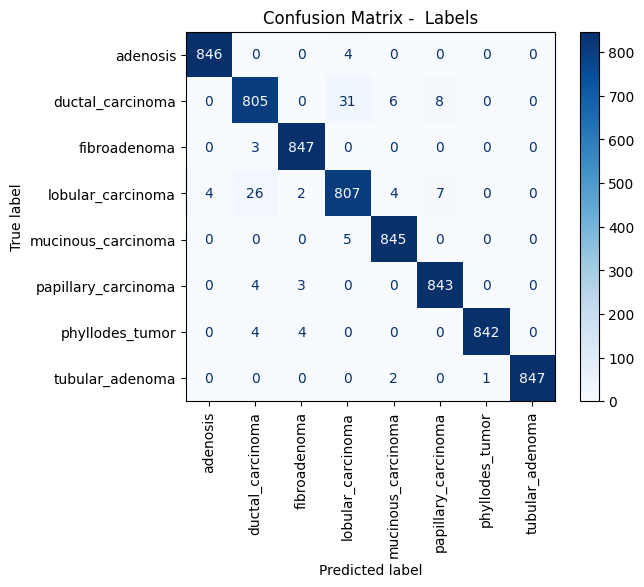

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------------------------
# 1. Predict labels for test set
# -------------------------------
y_pred_probs = model.predict(test_generator)       # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)           # predicted class indices
y_true = test_generator.classes                    # true class indices

# -------------------------------
# 2. Compute confusion matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

# -------------------------------
# 3. Display confusion matrix
# -------------------------------
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=list(test_generator.class_indices.keys())
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix -  Labels")
plt.show()

In [31]:
df = pd.DataFrame(history.history)
df['epoch'] = range(1, len(df) + 1)

df.to_csv('training_history.csv', index=False)